In [23]:
#import useful python libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN#utilizing DBSCAN for density-based clustering
from sklearn.preprocessing import StandardScaler # It transforms data such that it has a mean of 0 and a standard deviation of 1
import os
import random
import glob


In [24]:
os.chdir('D:\Mcvs_clermont\current working directory\cluster_groups')   # Change to subfolder
print("Now in:", os.getcwd())


Now in: D:\Mcvs_clermont\current working directory\cluster_groups


In [25]:

# Load the parquet file (replace with correct path if needed)
df = pd.read_csv("lightcurve_features_26_negative.parquet")

# View first few rows
df.head()


,object,mean,weighted_mean,standard_deviation,median,amplitude,beyond_1_std,cusum,inter_percentile_range_10,kurtosis,...,magnitude_percentage_ratio_20_10,maximum_slope,median_absolute_deviation,median_buffer_range_percentage_10,percent_amplitude,mean_variance,anderson_darling_normal,chi2,skew,stetson_K
0,ZTF17aaatdnl,16.474019,16.265769,0.655889,16.159328,2.216342,0.108881,0.239616,1.121193,5.080193,...,0.476100,896.175436,0.054062,0.681265,3.304615,0.039814,241.291275,454.107709,2.385774,0.765791
1,ZTF18aaawejy,16.510358,16.406240,0.425248,16.273313,1.010284,0.195536,0.356777,1.111182,0.273401,...,0.593552,669.958263,0.060773,0.612500,1.315850,0.025756,259.973064,541.683306,1.310183,0.795163
2,ZTF18aaphvtk,17.344563,16.750839,0.729764,17.723148,1.856989,0.135151,0.299635,1.655165,3.076823,...,0.457040,596.780858,0.153105,0.516301,3.273998,0.042075,169.896297,2942.566563,-1.916860,0.796064
3,ZTF18aawadfc,14.772833,14.772367,0.083390,14.770324,0.325024,0.556935,0.343321,0.204603,-0.675172,...,0.912447,888.048458,0.088786,0.202914,0.456098,0.005645,66.631091,49.674484,0.147798,0.887305
4,ZTF18aawccls,17.244160,17.142604,0.398646,17.278309,1.159980,0.431990,0.212555,1.089173,-0.760558,...,0.771138,519.031189,0.326796,0.287154,1.180918,0.023118,13.502721,328.469899,-0.108506,0.824070


In [26]:
id_col = "object"   # change this to your actual unique column name

# Check for duplicates
dupes = df[df.duplicated(subset=[id_col], keep=False)]

print("Total duplicates found:", len(dupes))

# View first few duplicate entries
dupes.sort_values(by=id_col).head(10)


Total duplicates found: 0


,object,mean,weighted_mean,standard_deviation,median,amplitude,beyond_1_std,cusum,inter_percentile_range_10,kurtosis,...,magnitude_percentage_ratio_20_10,maximum_slope,median_absolute_deviation,median_buffer_range_percentage_10,percent_amplitude,mean_variance,anderson_darling_normal,chi2,skew,stetson_K


In [27]:
# Load your negative sample
df_neg = pd.read_csv("lightcurve_features_26_negative.parquet")

In [28]:
features = df_neg.select_dtypes(include=[np.number]) #nonnumericals are dropped
X = StandardScaler().fit_transform(features) #standardize and transforming features

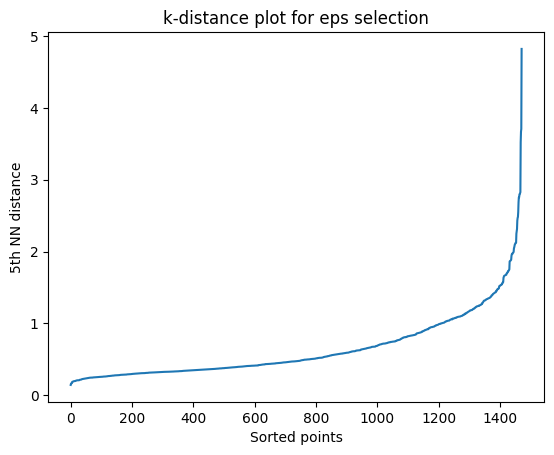

In [29]:
# Import K-nearest neighbors algorithm for estimating point density (used in DBSCAN)
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce feature space to 3 principal components for easier distance estimation
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a nearest-neighbors model using k = 5 neighbors
neigh = NearestNeighbors(n_neighbors=5)

# Fit the k-NN model on the PCA-transformed data
nbrs = neigh.fit(X_pca)

# Compute distances and indices of the 5 nearest neighbors for each sample
distances, indices = nbrs.kneighbors(X_pca)

# Extract and sort the distance to the 5th nearest neighbor
# This helps identify a threshold (eps) for DBSCAN
distances = np.sort(distances[:, 4])

# Plot the k-distance graph to visually choose DBSCAN eps (look for the "knee")
plt.plot(distances)
plt.ylabel("5th NN distance")
plt.xlabel("Sorted points")
plt.title("k-distance plot for eps selection")
plt.show()


In [30]:
#as the knee grooved between 2 and 3 lets calculate proper eps
for eps in [2.2, 2.3, 2.36, 2.4, 2.5, 2.6]:
    db = DBSCAN(eps=eps, min_samples=5).fit(X)
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    noise = list(db.labels_).count(-1)
    print(f"eps={eps}: clusters={n_clusters}, noise={noise}")

eps=2.2: clusters=4, noise=438
eps=2.3: clusters=9, noise=389
eps=2.36: clusters=11, noise=366
eps=2.4: clusters=8, noise=348
eps=2.5: clusters=8, noise=308
eps=2.6: clusters=7, noise=259


In [31]:
#  Cluster with DBSCAN,for 2.36 proper value
db = DBSCAN(eps=2.36, min_samples=5).fit(X)
df_neg["cluster"] = db.labels_

In [32]:
# Check number of clusters (excluding noise = -1)
clusters = [c for c in np.unique(db.labels_) if c != -1]
print(f"Found {len(clusters)} clusters: {clusters}")


Found 11 clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [33]:
labels = db.labels_
print("Unique labels:", np.unique(labels))
print("Noise points:", np.sum(labels == -1))
print("Non-noise points:", np.sum(labels != -1))


Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10]
Noise points: 366
Non-noise points: 1105


In [34]:
# === Create output folder ===
os.makedirs("cluster_groups", exist_ok=True)

# ===  Separate clusters and noise ===
clustered = df_neg[df_neg['cluster'] != -1]   # clustered data
noise = df_neg[df_neg['cluster'] == -1]       # noise data

# ===  Count elements per cluster ===
cluster_counts = clustered['cluster'].value_counts().sort_index()
print("Distribution of elements per cluster:")
print(cluster_counts)

# ===  Save each cluster into a separate file ===
for c in sorted(clustered['cluster'].unique()):
    subset = clustered[clustered['cluster'] == c]
    filename = f"cluster_groups_{c}.parquet"
    subset.to_parquet(filename, index=False)
    print(f"Saved {len(subset)} elements to {filename}")

# ===  Save noise elements ===
noise_filename = "cluster_groups_noise.parquet"
noise.to_parquet(noise_filename, index=False)
print(f"Saved {len(noise)} noise elements to {noise_filename}")

# ===  Optional summary file ===
summary = pd.DataFrame({
    'cluster': cluster_counts.index,
    'count': cluster_counts.values
})
summary.to_csv("cluster_summary.csv", index=False)
print("\nCluster summary saved to cluster_groups/cluster_summary.csv")


Distribution of elements per cluster:
cluster
0        7
1     1032
2       19
3        7
4        5
5        5
6        6
7        5
8        8
9        4
10       7
Name: count, dtype: int64
Saved 7 elements to cluster_groups_0.parquet
Saved 1032 elements to cluster_groups_1.parquet
Saved 19 elements to cluster_groups_2.parquet
Saved 7 elements to cluster_groups_3.parquet
Saved 5 elements to cluster_groups_4.parquet
Saved 5 elements to cluster_groups_5.parquet
Saved 6 elements to cluster_groups_6.parquet
Saved 5 elements to cluster_groups_7.parquet
Saved 8 elements to cluster_groups_8.parquet
Saved 4 elements to cluster_groups_9.parquet
Saved 7 elements to cluster_groups_10.parquet
Saved 366 noise elements to cluster_groups_noise.parquet

Cluster summary saved to cluster_groups/cluster_summary.csv


In [47]:
# Set working directory ===
cluster_dir = r"D:\Mcvs_clermont\current working directory\cluster_groups"
os.chdir(cluster_dir)

In [48]:
#  Read all cluster parquet files (excluding noise) ===
cluster_files = sorted(glob.glob(r"D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_*.parquet"))
cluster_files = [f for f in cluster_files if "noise" not in f]

In [54]:
#checking groups created or not
cluster_dir = r"D:\Mcvs_clermont\current working directory\cluster_groups"
os.chdir(cluster_dir)

files = glob.glob("cluster_groups*.parquet")
print("Found files:", files)


Found files: ['cluster_groups_0.parquet', 'cluster_groups_1.parquet', 'cluster_groups_10.parquet', 'cluster_groups_2.parquet', 'cluster_groups_3.parquet', 'cluster_groups_4.parquet', 'cluster_groups_5.parquet', 'cluster_groups_6.parquet', 'cluster_groups_7.parquet', 'cluster_groups_8.parquet', 'cluster_groups_9.parquet', 'cluster_groups_noise.parquet']


In [55]:
# === Step 1: Set working directory ===
cluster_dir = r"D:\Mcvs_clermont\current working directory\cluster_groups"
os.chdir(cluster_dir)

In [56]:
# === Step 2: Read all cluster parquet files (excluding noise) ===
cluster_files = sorted(glob.glob(r"D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_*.parquet"))
cluster_files = [f for f in cluster_files if "noise" not in f]

In [57]:
#loading cluster files
clusters = []
for f in cluster_files:
    try:
        df = pd.read_parquet(f)
        if len(df) == 0:
            print(f"Skipping {f} (empty)")
            continue
        df["cluster_id"] = f.split("_")[-1].split(".")[0]
        clusters.append(df)
        print(f" Loaded {f} with {len(df)} rows")
    except Exception as e:
        print(f" Could not read {f}: {e}")

    

 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_0.parquet with 7 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_1.parquet with 1032 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_10.parquet with 7 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_2.parquet with 19 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_3.parquet with 7 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_4.parquet with 5 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_5.parquet with 5 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_6.parquet with 6 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cluster_groups_7.parquet with 5 rows
 Loaded D:\Mcvs_clermont\current working directory\cluster_groups\cl

In [58]:
#if not clusters:
 #   raise ValueError("No valid cluster files found or all were empty!")

all_data = pd.concat(clusters, ignore_index=True)
print(f"\nTotal combined elements: {len(all_data)}")



Total combined elements: 1105


In [59]:
# === Step 3: Shuffle all elements ===
all_data = all_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [60]:
# === Step 4: Split into 13 groups (each with 85 elements) ===
group_size = 85
groups = [all_data.iloc[i*group_size:(i+1)*group_size] for i in range(13)]

In [61]:
# === Step 5: Save each group ===
for i, g in enumerate(groups):
    out_file = os.path.join(cluster_dir, f"negative_subset_group_{i+1}.parquet")
    g.to_parquet(out_file, index=False)
    print(f"Saved {len(g)} elements to {out_file}")

Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_1.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_2.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_3.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_4.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_5.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_6.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_7.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_8.parquet
Saved 85 elements to D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_9.parquet
S

In [62]:
# === Optional: Check cluster distribution in each group ===
for i, g in enumerate(groups):
    print(f"\nGroup {i+1} cluster counts:")
    print(g["cluster_id"].value_counts())


Group 1 cluster counts:
cluster_id
1     80
10     1
8      1
6      1
2      1
4      1
Name: count, dtype: int64

Group 2 cluster counts:
cluster_id
1    84
8     1
Name: count, dtype: int64

Group 3 cluster counts:
cluster_id
1    76
2     3
0     3
4     1
8     1
5     1
Name: count, dtype: int64

Group 4 cluster counts:
cluster_id
1    83
3     1
2     1
Name: count, dtype: int64

Group 5 cluster counts:
cluster_id
1    78
2     2
0     1
4     1
6     1
3     1
9     1
Name: count, dtype: int64

Group 6 cluster counts:
cluster_id
1    76
2     4
3     3
5     1
0     1
Name: count, dtype: int64

Group 7 cluster counts:
cluster_id
1    81
9     1
8     1
4     1
2     1
Name: count, dtype: int64

Group 8 cluster counts:
cluster_id
1    82
6     1
2     1
3     1
Name: count, dtype: int64

Group 9 cluster counts:
cluster_id
1     80
10     1
2      1
6      1
5      1
9      1
Name: count, dtype: int64

Group 10 cluster counts:
cluster_id
1     75
7      3
10     3
4      1
3    

In [67]:
# Load the parquet file
df_noise = pd.read_parquet(r"D:\Mcvs_clermont\current working directory\cluster_groups\negative_subset_group_14_noise.parquet")

# View first few rows
df_noise.head()
print(df_noise.shape)


(366, 28)


In [69]:

# Find all 14 parquet files
neg_files = sorted(glob.glob("negative_subset_group*.parquet"))


In [70]:
neg_files

['negative_subset_group_1.parquet',
 'negative_subset_group_10.parquet',
 'negative_subset_group_11.parquet',
 'negative_subset_group_12.parquet',
 'negative_subset_group_13.parquet',
 'negative_subset_group_14_noise.parquet',
 'negative_subset_group_2.parquet',
 'negative_subset_group_3.parquet',
 'negative_subset_group_4.parquet',
 'negative_subset_group_5.parquet',
 'negative_subset_group_6.parquet',
 'negative_subset_group_7.parquet',
 'negative_subset_group_8.parquet',
 'negative_subset_group_9.parquet']